# mAP for phenotypic activity assesement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copairs import map
from copairs.matching import assign_reference_index

## Introduction

This example demostrates how to use `copairs` to assess phenotypic activity of perturbations in a profiling dataset.

Phenotypic activity is assessed by calculating mean average precision (mAP) for the retrieval of replicates of a perturbation against replicates of negative controls.

It aims to answer the question: “How distinguishable is this perturbation from negative controls?”

The resulting perturbation mAP score reflects the average extent to which its replicate profiles are more similar to each other compared to control profiles (Figure 1E).

Citation:
> Kalinin, A.A., Arevalo, J., Serrano, E., Vulliard, L., Tsang, H., Bornholdt, M., Muñoz, A.F., Sivagurunathan, S., Rajwa, B., Carpenter, A.E., Way, G.P. and Singh, S., 2025. A versatile information retrieval framework for evaluating profile strength and similarity. _Nature Communications_ 16, 5181. doi:10.1038/s41467-025-60306-2

In [2]:
# these imports are only needed for showing Figure 1 from the paper
from io import BytesIO
from pathlib import Path

import requests
from PIL import Image
from IPython.display import display

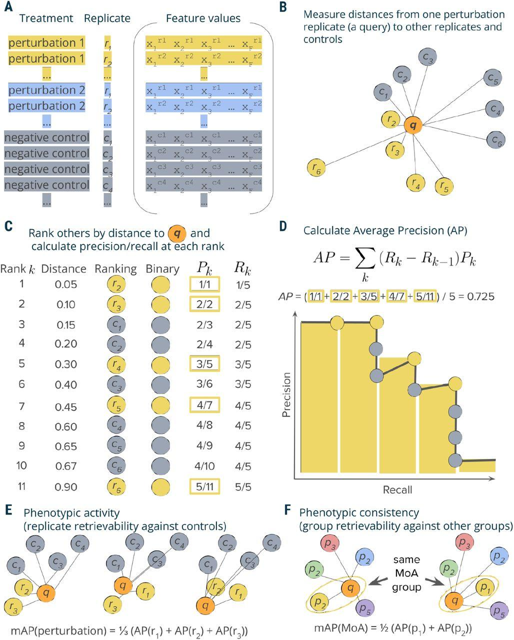

In [3]:
fig1_path = "data/F1.large.jpg"
fig1_url = "https://www.biorxiv.org/content/biorxiv/early/2024/04/02/2024.04.01.587631/F1.large.jpg"

if not Path(fig1_path).is_file():
    image = Image.open(BytesIO(requests.get(fig1_url).content))
    image.save(fig1_path)

image = Image.open(fig1_path).resize((514, 640))
display(image)

## Download data

Download a single plate of profiles from the dataset "cpg0004" (aka LINCS), which contains Cell Painting images of 1,327 small-molecule perturbations of A549 human cells. The wells on each plate were perturbed with 56 different compounds in six different doses.

> Way, G. P. et al. Morphology and gene expression profiling provide complementary information for mapping cell state. Cell Syst 13, 911–923.e9 (2022).

In [4]:
local_path = "data/2016_04_01_a549_48hr_batch1_plateSQ00014812.csv"
commit = "da8ae6a3bc103346095d61b4ee02f08fc85a5d98"
plate = "SQ00014812"
url = f"https://media.githubusercontent.com/media/broadinstitute/lincs-cell-painting/{commit}/profiles/2016_04_01_a549_48hr_batch1/{plate}/{plate}_normalized_feature_select.csv.gz"

if not Path(local_path).is_file():
    df = pd.read_csv(url)
    df.to_csv(local_path, index=False)
else:
    df = pd.read_csv(local_path)

df = df.loc[:, df.nunique() > 1]  # remove constant columns
df

Metadata_broad_sample  Metadata_mg_per_ml  Metadata_mmoles_per_liter  \
0                      DMSO            0.000000                   0.000000   
1                      DMSO            0.000000                   0.000000   
2                      DMSO            0.000000                   0.000000   
3                      DMSO            0.000000                   0.000000   
4                      DMSO            0.000000                   0.000000   
..                      ...                 ...                        ...   
379  BRD-K82746043-001-15-1            3.248700                   3.333300   
380  BRD-K82746043-001-15-1            1.082900                   1.111100   
381  BRD-K82746043-001-15-1            0.360970                   0.370370   
382  BRD-K82746043-001-15-1            0.120320                   0.123460   
383  BRD-K82746043-001-15-1            0.040108                   0.041152   

    Metadata_pert_id    Metadata_pert_mfc_id Metadata_pert_well  \
0                NaN                     NaN                A01   
1                NaN                     NaN                A02   
2                NaN                     NaN                A03   
3                NaN                     NaN                A04   
4                NaN                     NaN                A05   
..               ...                     ...                ...   
379    BRD-K82746043  BRD-K82746043-001-15-1                P20   
380    BRD-K82746043  BRD-K82746043-001-15-1                P21   
381    BRD-K82746043  BRD-K82746043-001-15-1                P22   
382    BRD-K82746043  BRD-K82746043-001-15-1                P23   
383    BRD-K82746043  BRD-K82746043-001-15-1                P24   

    Metadata_broad_sample_type Metadata_pert_type Metadata_broad_id  \
0                      control            control               NaN   
1                      control            control               NaN   
2                      control            control               NaN   
3                      control            control               NaN   
4                      control            control               NaN   
..                         ...                ...               ...   
379                        trt                trt     BRD-K82746043   
380                        trt                trt     BRD-K82746043   
381                        trt                trt     BRD-K82746043   
382                        trt                trt     BRD-K82746043   
383                        trt                trt     BRD-K82746043   

    Metadata_InChIKey14  ... Nuclei_Texture_InverseDifferenceMoment_AGP_5_0  \
0                   NaN  ...                                        -1.3544   
1                   NaN  ...                                        -2.3840   
2                   NaN  ...                                        -1.9493   
3                   NaN  ...                                        -2.2909   
4                   NaN  ...                                        -1.8955   
..                  ...  ...                                            ...   
379      JLYAXFNOILIKPP  ...                                        -6.1522   
380      JLYAXFNOILIKPP  ...                                        -5.1586   
381      JLYAXFNOILIKPP  ...                                        -5.9475   
382      JLYAXFNOILIKPP  ...                                        -8.4408   
383      JLYAXFNOILIKPP  ...                                        -7.9510   

    Nuclei_Texture_InverseDifferenceMoment_DNA_20_0  \
0                                          -1.07770   
1                                          -0.73440   
2                                          -0.36148   
3                                          -0.46380   
4                                          -1.05350   
..                                              ...   
379                                         1.81410   
380                   

Note that in this dataset, pertubations can target multiple genes. We can list these targets from the `Metadata_target` column.

In [5]:
df["Metadata_target"].unique()

array([nan, 'CHRM1|CHRM2|CHRM3|CHRM4|CHRM5', 'HMGCR',
       'HDAC1|HDAC2|HDAC3|HDAC9', 'ERBB2', 'DNMT1|DNMT3A',
       'GABRA1|GABRA2|GABRA3|GABRA4|GABRA5|GABRA6', 'TUBB', 'KIF11',
       'PSMA1|PSMA2|PSMA3|PSMA4|PSMA5|PSMA6|PSMA7|PSMA8|PSMB1|PSMB10|PSMB11|PSMB2|PSMB3|PSMB4|PSMB5|PSMB6|PSMB7|PSMB8|PSMB9|PSMD1|PSMD2|RELA',
       'SQLE', 'GABRA1', 'KCNT2|TRPV4', 'AURKA|AURKB',
       'DRD2|GRIN2A|GRIN2B|GRIN2C|GRIN2D|GRIN3A', 'CFTR',
       'CACNA1C|CACNA1S|CACNA2D1|CACNG1|HTR3A|KCNA5',
       'ADRA1A|ADRA1B|ADRA2A|ADRA2B|ADRA2C|CHRM1|CHRM2|CHRM3|CHRM4|CHRM5|DRD1|DRD2|DRD3|DRD4|DRD5|HRH1|HTR1A|HTR1B|HTR1D|HTR1E|HTR2A|HTR2C|HTR3A|HTR6|HTR7',
       'EGFR|NR1I2', 'ADRA1A|ADRA2A|HRH1|HTR1A|HTR2A|HTR2B|HTR2C|SLC6A4',
       'EGFR|ERBB2', 'HIF1A', 'ESR1|ESR2|MAP1A|MAP2', 'SCN4A|SCN9A',
       'BIRC2|XIAP', 'AKT1|AKT2|AKT3|PRKG1', 'ACE',
       'HTR1A|HTR1B|HTR1D|HTR1E|HTR1F|HTR2A|HTR2B|HTR2C|HTR5A|HTR6|HTR7',
       'CYSLTR1|CYSLTR2', 'GAST', 'HTR1A', 'PSMB1', 'MET', 'NAE1|UBA3',
       'VD

## Assessing phenotypic activity of compounds with mAP

Here, we treat different doses of each compound as replicates and assess how well we can retrieve them by similarity against the group of negative controls (DMSO).

For phenotypic activity, it's helpful to add an extra column that is equal to row index for all DMSO replicates and to -1 for all compound replicates using `assign_reference_index` function. This helps to not count groups of negative controls as query groups and not consider other perturbations as a reference.

In [6]:
reference_col = "Metadata_reference_index"

df_activity = assign_reference_index(
    df,
    "Metadata_broad_sample == 'DMSO'",  # condition to get reference profiles (neg controls)
    reference_col=reference_col,
    default_value=-1,
)

Next, we define the rules by which profiles are grouped based on metadata:

* Two profiles are a positive pair if they belong to the same group that is not a control group. In this case, any two replicate profiles of the same compound are a positive pair. To define that using metadata columns, positive pairs should share the same value in the metadata column that identifies compounds (`Metadata_broad_sample`). We add this column to a list names `pos_sameby`.

* In this case, profiles that form a positive pair do not need to be different in any of the metatada columns, so we keep `pos_diffby` empty. Although one could define them as being from different batches, for instance, to account for batch effects.

* Two profiles are a negative pair when one of them belongs to a group of compound replicates and another to a group of DMSO controls. That means they should be different both in the metadata column that identifies the specific compound and the reference index columns that we created. The latter is needed to ensure that replicates of compounds are retrieved against only DMSO controls at this stage (and not against replicates of other compounds). We list these columns in `neg_diffby`.

* Profiles that form a negative pair do not need to be same in any of the metatada columns, so we keep `neg_sameby` empty.


Finally, we include `Metadata_reference_index` column to:
* `pos_sameby`—this ensures positive pairs connect profiles that share the same value in this column, i.e. a positive pair cannot be formed between any two negative controls (control profiles contain index values).
*  `neg_diffby`—this ensures negative pairs connect profiles that differ in this columns, i.e. a negative pair cannot be formed between profiles of two different perturbations (all perturbation profiles contain -1).

In [7]:
# positive pairs are replicates of the same treatment
pos_sameby = ["Metadata_broad_sample", reference_col]
pos_diffby = []

neg_sameby = []
# negative pairs are replicates of different treatments
neg_diffby = ["Metadata_broad_sample", reference_col]

Now we can use `average_precision` function to calculate the average precision score for each replicate of each compound.

It returns metadata with 3 new columns: number of positive and negative pairs for each replicate profile and the average precision score.

In [8]:
metadata = df_activity.filter(regex="^Metadata")
profiles = df_activity.filter(regex="^(?!Metadata)").values

activity_ap = map.average_precision(
    metadata, profiles, pos_sameby, pos_diffby, neg_sameby, neg_diffby
)
activity_ap = activity_ap.query("Metadata_broad_sample != 'DMSO'")  # remove DMSO
activity_ap.to_csv("data/activity_ap.csv", index=False)
activity_ap

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metadata_broad_sample  Metadata_mg_per_ml  Metadata_mmoles_per_liter  \
6    BRD-K74363950-004-01-0            5.655600                  10.000000   
7    BRD-K74363950-004-01-0            1.885200                   3.333300   
8    BRD-K74363950-004-01-0            0.628400                   1.111100   
9    BRD-K74363950-004-01-0            0.209470                   0.370370   
10   BRD-K74363950-004-01-0            0.069823                   0.123460   
..                      ...                 ...                        ...   
379  BRD-K82746043-001-15-1            3.248700                   3.333300   
380  BRD-K82746043-001-15-1            1.082900                   1.111100   
381  BRD-K82746043-001-15-1            0.360970                   0.370370   
382  BRD-K82746043-001-15-1            0.120320                   0.123460   
383  BRD-K82746043-001-15-1            0.040108                   0.041152   

    Metadata_pert_id    Metadata_pert_mfc_id Metadata_pert_well  \
6      BRD-K74363950  BRD-K74363950-004-01-0                A07   
7      BRD-K74363950  BRD-K74363950-004-01-0                A08   
8      BRD-K74363950  BRD-K74363950-004-01-0                A09   
9      BRD-K74363950  BRD-K74363950-004-01-0                A10   
10     BRD-K74363950  BRD-K74363950-004-01-0                A11   
..               ...                     ...                ...   
379    BRD-K82746043  BRD-K82746043-001-15-1                P20   
380    BRD-K82746043  BRD-K82746043-001-15-1                P21   
381    BRD-K82746043  BRD-K82746043-001-15-1                P22   
382    BRD-K82746043  BRD-K82746043-001-15-1                P23   
383    BRD-K82746043  BRD-K82746043-001-15-1                P24   

    Metadata_broad_sample_type Metadata_pert_type Metadata_broad_id  \
6                          trt                trt     BRD-K74363950   
7                          trt                trt     BRD-K74363950   
8                          trt                trt     BRD-K74363950   
9                          trt                trt     BRD-K74363950   
10                         trt                trt     BRD-K74363950   
..                         ...                ...               ...   
379                        trt                trt     BRD-K82746043   
380                        trt                trt     BRD-K82746043   
381                        trt                trt     BRD-K82746043   
382                        trt                trt     BRD-K82746043   
383                        trt                trt     BRD-K82746043   

    Metadata_InChIKey14                       Metadata_moa  \
6        ASMXXROZKSBQIH  acetylcholine receptor antagonist   
7        ASMXXROZKSBQIH  acetylcholine receptor antagonist   
8        ASMXXROZKSBQIH  acetylcholine receptor antagonist   
9        ASMXXROZKSBQIH  acetylcholine receptor antagonist   
10       ASMXXROZKSBQIH  acetylcholine receptor antagonist   
..                  ...                                ...   
379      JLYAXFNOILIKPP                      BCL inhibitor   
380      JLYAXFNOILIKPP                      BCL inhibitor   
381      JLYAXFNOILIKPP                      BCL inhibitor   
382      JLYAXFNOILIKPP                      BCL inhibitor   
383      JLYAXFNOILIKPP                      BCL inhibitor   

                   Metadata_target Metadata_broad_date Metadata_Well  \
6    CHRM1|CHRM2|CHRM3|CHRM4|CHRM5   broad_id_20170327           A07   
7    CHRM1|CHRM2|CHRM3|CHRM4|CHRM5   broad_id_20170327           A08   
8    CHRM1|CHRM2|CHRM3|CHRM4|CHRM5   broad_id_20170327           A09   
9    CHRM1|CHRM2|CHRM3|CHRM4|CHRM5   broad_id_20170327           A10   
10   CHRM1|CHRM2|CHRM3|CHRM4|CHRM5   broad_id_20170327           A11   
..                             ...                 ...           ...   
379             BCL2|BCL2L1|BCL2L2   broad_id_20170327           P20   
380             BCL2|BCL2L1|BCL2L2   broad_id_20170327           P21   
381             BC

At the next step, we average replicate AP scores at the per-compound level to obtain mAP values using `mean_average_precision`.

It also calculates p-values using permutation testing, and performs FDR correction to compare across compounds.

For more information on choosing `null size` parameter see the [Null size](./null_size.ipynb) example.

In [9]:
activity_map = map.mean_average_precision(
    activity_ap, pos_sameby, null_size=1000000, threshold=0.05, seed=0
)
activity_map["-log10(p-value)"] = -activity_map["corrected_p_value"].apply(np.log10)
activity_map.head(10)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Metadata_broad_sample  Metadata_reference_index  mean_average_precision  \
0  BRD-A69275535-001-01-5                        -1                0.575629   
1  BRD-A69636825-003-04-7                        -1                0.693806   
2  BRD-A69815203-001-07-6                        -1                1.000000   
3  BRD-A70858459-001-01-7                        -1                0.777173   
4  BRD-A72309220-001-04-1                        -1                0.716927   
5  BRD-A72390365-001-15-2                        -1                0.934444   
6  BRD-A73368467-003-17-6                        -1                0.926032   
7  BRD-A74980173-001-11-9                        -1                0.765931   
8  BRD-A81233518-004-16-1                        -1                0.621183   
9  BRD-A82035391-001-02-7                        -1                0.318066   

                          indices       p_value  corrected_p_value  below_p  \
0      [96, 97, 98, 99, 100, 101]  1.725598e-02           0.023276     True   
1  [114, 115, 116, 117, 118, 119]  3.477997e-03           0.006507     True   
2  [288, 289, 290, 291, 292, 293]  9.999990e-07           0.000008     True   
3  [156, 157, 158, 159, 160, 161]  8.279992e-04           0.001921     True   
4  [192, 193, 194, 195, 196, 197]  2.323998e-03           0.004493     True   
5  [210, 211, 212, 213, 214, 215]  2.799997e-05           0.000108     True   
6  [246, 247, 248, 249, 250, 251]  3.699996e-05           0.000134     True   
7        [18, 19, 20, 21, 22, 23]  1.017999e-03           0.002187     True   
8  [306, 307, 308, 309, 310, 311]  9.594990e-03           0.014269     True   
9  [342, 343, 344, 345, 346, 347]  2.536767e-01           0.258127    False   

   below_corrected_p  -log10(p-value)  
0               True         1.633101  
1               True         2.186605  
2               True         5.081670  
3               True         2.716482  
4               True         2.347458  
5               True         3.965506  
6               True         3.872491  
7               True         2.660188  
8               True         1.845592  
9              False         0.588166

Finally, we can plot the results and filter out phenotypicall inactive compounds with corrected p-value >0.05.

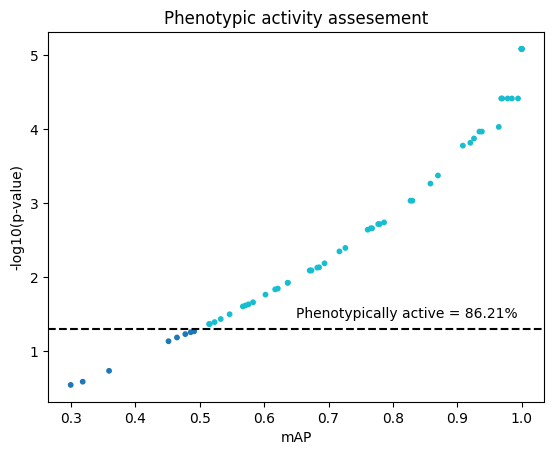

In [10]:
active_ratio = activity_map.below_corrected_p.mean()

plt.scatter(
    data=activity_map,
    x="mean_average_precision",
    y="-log10(p-value)",
    c="below_corrected_p",
    cmap="tab10",
    s=10,
)
plt.title("Phenotypic activity assesement")
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(
    0.65,
    1.5,
    f"Phenotypically active = {100 * active_ratio:.2f}%",
    va="center",
    ha="left",
)
plt.show()

In [11]:
activity_map.to_csv("data/activity_map.csv", index=False)